In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 6.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2021-06-24 03:41:30--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2021-06-24 03:41:30 (34.3 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [ ]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [ ]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 24)                2496      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 2s 196ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 9/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0087
Epoch 10/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 11/100
4/4 [

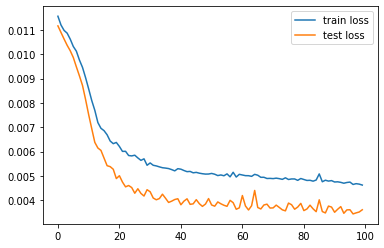

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [ ]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

In [ ]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

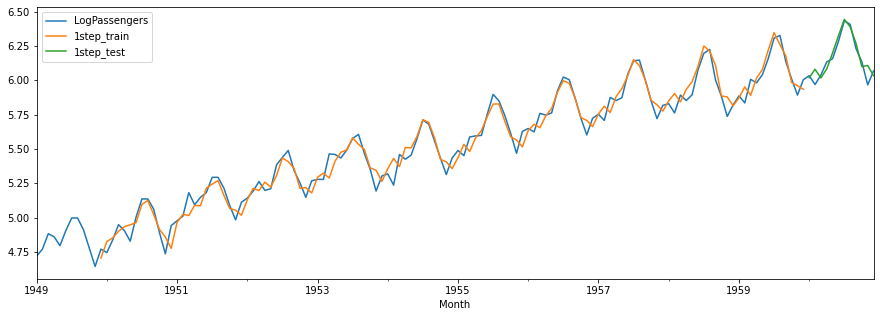

In [ ]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [ ]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

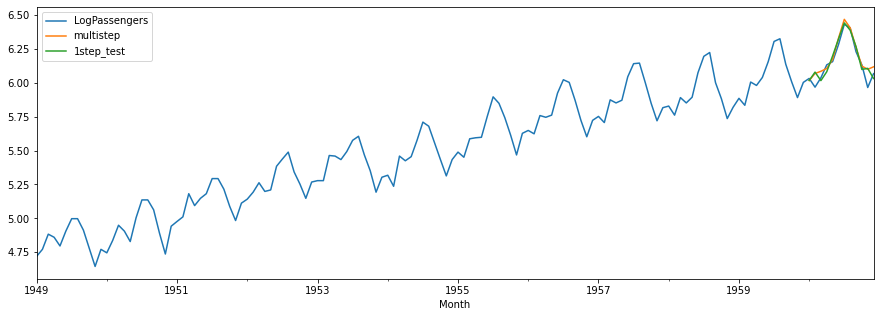

In [ ]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [ ]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [ ]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [ ]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [ ]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 2s 151ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 2/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 3/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 4/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 5/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 6/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 7/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 8/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 9/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 10/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 11/300
4/4 [

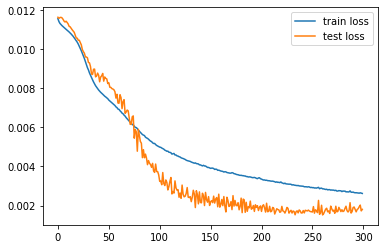

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [ ]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [ ]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [ ]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

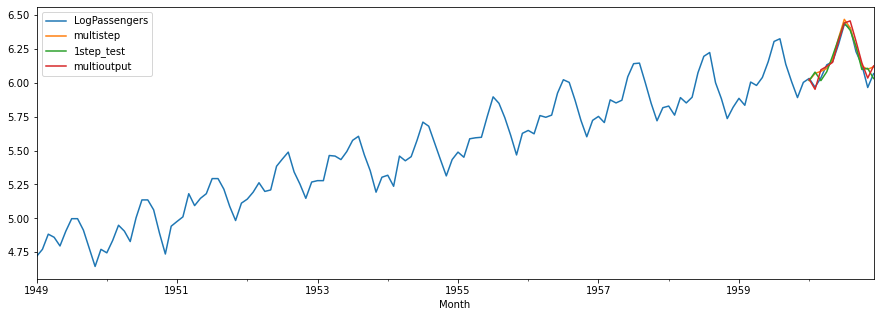

In [ ]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [ ]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [ ]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 4s 242ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 2/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 3/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 4/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 6/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 7/300
4/4 [==============================] - 0s 15ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 8/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 9/300
4/4 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 10/300
4/4 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 11/300
4/4 [

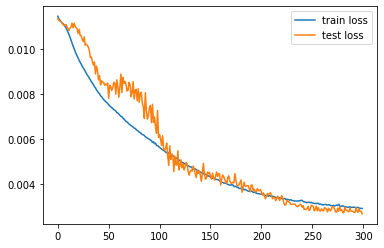

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [ ]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

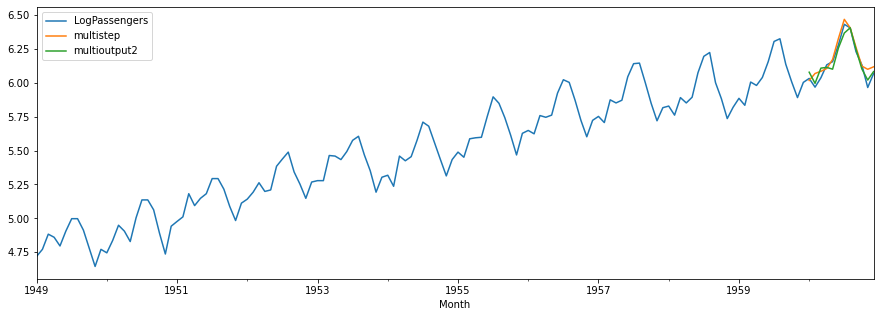

In [ ]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', 'multioutput2']
df[cols].plot(figsize=(15, 5));

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.0070863595384320485
multi-output MAPE: 0.005456234203940059
multi-output (2 LSTMs) MAPE: 0.005795274393870151


In [ ]:
# Exercise:
# Is the improvement due to global max pooling? Or due to multiple LSTMs layers?
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?